In [3337]:
%pylab inline
indir = '/mnt/store1/oliverphilcox/3PCF_SE_2/3PCFCovMatricesAll/'
n=15
l=4
m=l+1

Populating the interactive namespace from numpy and matplotlib


# Must include $(6V(nw)^3)^2$ normalization

In [3338]:
def symmetrize(mat):
    """ Add in symmetries to matrices """
    out_mat = np.zeros_like(mat)
    for i in range(len(mat)//m):
        a = i//n
        b = i%n
        for j in range(len(mat)//m):
            c = j//n
            d = j%n
            # Add to all relevant bins
            these_mat = mat[i*m:(i+1)*m,j*m:(j+1)*m]*0.25
            out_mat[(a*n+b)*m:(a*n+b)*m+m,(c*n+d)*m:(c*n+d)*m+m]+=these_mat
            out_mat[(b*n+a)*m:(b*n+a)*m+m,(c*n+d)*m:(c*n+d)*m+m]+=these_mat
            out_mat[(b*n+a)*m:(b*n+a)*m+m,(d*n+c)*m:(d*n+c)*m+m]+=these_mat
            out_mat[(a*n+b)*m:(a*n+b)*m+m,(d*n+c)*m:(d*n+c)*m+m]+=these_mat
    return 0.5*(out_mat+out_mat.T)

In [3339]:
def plotter(mat,vmax=np.inf,perc=99,rmax=0):
    if vmax==np.inf:
        vmax=np.percentile(mat,perc)
    plt.matshow(mat,vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r);
    plt.colorbar();
    if rmax==0:
        rmax = len(mat)
    plt.ylim([-0.5,rmax-0.5])
    plt.xlim([-0.5,rmax-0.5])

In [3340]:
def rebinner(mat):
    out_mat = np.zeros_like(mat)
    for i in range(m):
        for j in range(m):
            out_mat[i*n*n:(i+1)*n*n,j*n*n:(j+1)*n*n]=mat[i::m,j::m]
    return out_mat

In [3346]:
total_counts = np.loadtxt('/mnt/store1/oliverphilcox/3PCF_SE_2/3PCFCovMatricesAll/total_counts_n%d_l%d_0.txt'%(n,l))

In [3347]:
print("Triples: %.1e Quads: %.1e, Quints: %.1e, Hexes: %.1e"%(total_counts[0],total_counts[1],total_counts[2],total_counts[3]))

Triples: 5.1e+08 Quads: 1.0e+09, Quints: 2.1e+09, Hexes: 4.1e+09


In [3348]:
bins_r = np.loadtxt('/mnt/store1/oliverphilcox/3PCF/SE_binning_n15.csv')

In [3349]:
print('Radial Bins')
print(bins_r[:,0])
print(bins_r[:,1])
delta_r = bins_r[-1,0]-bins_r[-2,0]

Radial Bins
[ 30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130. 140. 150. 160.
 170.]
[ 40.  50.  60.  70.  80.  90. 100. 110. 120. 130. 140. 150. 160. 170.
 180.]


In [3350]:
c30=np.loadtxt(indir+'c3_n%d_l%d_0_full.txt'%(n,l))
c40=np.loadtxt(indir+'c4_n%d_l%d_0_full.txt'%(n,l))
c50=np.loadtxt(indir+'c5_n%d_l%d_0_full.txt'%(n,l))
c60=np.loadtxt(indir+'c6_n%d_l%d_0_full.txt'%(n,l))
c31=np.loadtxt(indir+'c3_n%d_l%d_1_full.txt'%(n,l))
c41=np.loadtxt(indir+'c4_n%d_l%d_1_full.txt'%(n,l))
c51=np.loadtxt(indir+'c5_n%d_l%d_1_full.txt'%(n,l))
c61=np.loadtxt(indir+'c6_n%d_l%d_1_full.txt'%(n,l))
c3=c30+c31
c4=c40+c41
c5=c50+c51
c6=c60+c61

In [3351]:
c3s=symmetrize(c3)
c4s=symmetrize(c4)
c5s=symmetrize(c5)
c6s=symmetrize(c6)

In [3360]:
c3so=c3s
c4so=c4s
c5so=c5s
c6so=c6s
c6o0=c60
c6o1=c61

(0, 100)

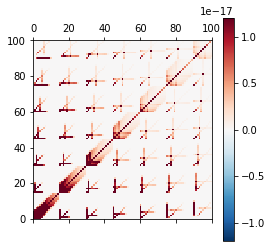

In [3361]:
plotter(c3s[::m,::m])
plt.ylim([0,100])
plt.xlim([0,100])

# Why are the two 3-point terms different?

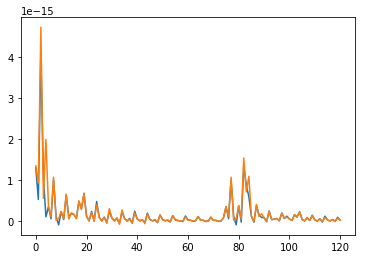

In [3362]:
plt.plot(np.diag(symmetrize(c30)[:121]))
plt.plot(np.diag(symmetrize(c31)[:121]))

## Use SE compression

In [3363]:
good_r_bins=[]
for b1 in range(n):
    for b2 in range(n):
        r1=bins_r[b1,0]
        r2=bins_r[b2,0]
        if (r2>=3*delta_r) and (r2<r1-3*delta_r):
            good_r_bins.append(b1)
good_r_bins = np.unique(np.asarray(good_r_bins))
n_g = len(good_r_bins)
min_r_bin = min(good_r_bins)

In [3364]:
def compression(mat):
    comp_mat = np.zeros([n_g*m,n_g*m])
    den = np.zeros([n_g*m,n_g*m])

    all_v = 4.*np.pi*(bins_r[:,1]**3-bins_r[:,0]**3)/3

    for i in range(len(mat)):
        l = i%m
        b1 = (i//m)//n
        r1 = bins_r[b1,0]
        if b1<min_r_bin:
            continue
        b2 = (i//m)%n
        r2 = bins_r[b2,0]
        if (r2>=3*delta_r) and (r2<r1-3*delta_r):
            v_b2 = all_v[b2]

            for j in range(len(mat)):
                l2 = j%m
                b3 = (j//m)//n
                r3 = bins_r[b3,0]
                if b3<min_r_bin:
                    continue
                b4 = (j//m)%n
                r4 = bins_r[b4,0]
                if (r4>=3*delta_r) and (r4<r3-3*delta_r):
                    v_b4 = all_v[b4]

                    comp_mat[l*n_g+b1-min_r_bin,l2*n_g+b3-min_r_bin]+=mat[i,j]*v_b2*v_b4
                    den[l*n_g+b1-min_r_bin,l2*n_g+b3-min_r_bin]+=v_b2*v_b4

    comp_mat/=den
    return comp_mat

In [3365]:
c3se=compression(c3s)
c4se=compression(c4s)
c5se=compression(c5s)
c6se=compression(c6s)

In [3366]:
c3seo=compression(c3so)
c4seo=compression(c4so)
c5seo=compression(c5so)
c6seo=compression(c6so)

In [3367]:
c60_old=compression(symmetrize(c6o0))
c61_old=compression(symmetrize(c6o1))
c60_new=compression(symmetrize(c60))
c61_new=compression(symmetrize(c61))

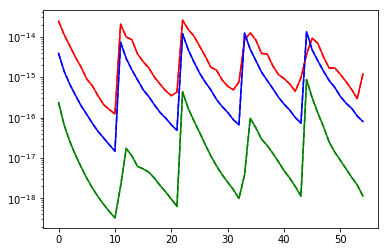

In [3368]:
plt.plot(np.diag(c5se),c='r')
plt.plot(np.diag(c4se),c='b')
plt.plot(np.diag(c3se),c='g')
plt.plot(np.diag(c5seo),c='r',ls='--')
plt.plot(np.diag(c4seo),c='b',ls='--')
plt.plot(np.diag(c3seo),c='g',ls='--')
plt.yscale('log');

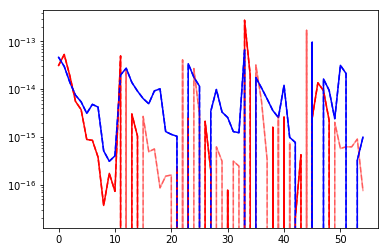

In [3371]:
plt.plot((np.diag(c60_old)),c='r')
plt.plot(-(np.diag(c60_old)),c='r',alpha=0.4)
plt.plot(np.diag(c61_old),c='b')
plt.plot((np.diag(c60_new)),c='r',ls='--')
plt.plot(-(np.diag(c60_new)),c='r',ls='--',alpha=0.4)
plt.plot(np.diag(c61_new),c='b',ls='--')
plt.yscale('log');

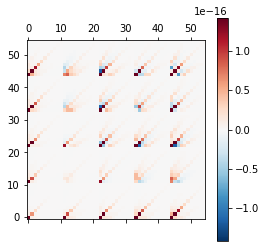

In [3372]:
plotter(c3se)

In [3377]:
input_xi = np.loadtxt('/mnt/store1/oliverphilcox/QPM_xi/QPM_mean.xi',skiprows=2)
xi_r = np.genfromtxt('/mnt/store1/oliverphilcox/QPM_xi/QPM_mean.xi',max_rows=1)

In [3378]:
mu_int_xi_r = np.sum(input_xi,axis=1)*1./input_xi.shape[1]

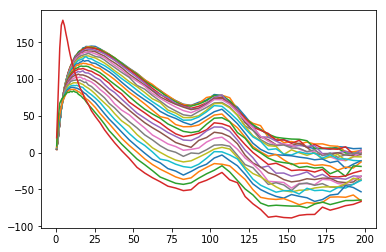

In [3379]:
for i in range(24):
    plt.plot(xi_r,input_xi[:,i]*xi_r**2)

In [3380]:
from scipy.interpolate import interp2d,interp1d
xi_mu = np.arange(0.,1.,1./input_xi.shape[1])
interp=interp2d(xi_r,xi_mu,xi_r**2*input_xi.T)
r_max = max(xi_r)
r_min = min(xi_r)

def xi_interp(r,mu,m=1.3):
    if r>r_max:
        return interp(r_max,mu)*pow(r/r_max,-m)/r_max**2
    elif r<r_min:
        return interp(r_min,mu)/r_min**2
    else:
        return interp(r,mu)/r**2

interp_r = interp1d(xi_r,xi_r**2*input_xi.mean(axis=1))
def xi_interp_r(r,m=4):
    if r>r_max:
        return interp_r(r_max)/r_max**2*pow(r/r_max,-m)
    elif r<r_min:
        return interp_r(r_min)/r_min**2
    else:
        return interp_r(r)/r**2

In [2977]:
for m in linspace(0.80,0.83,10):
    mu_all = np.linspace(0,1,200)
    xi_all=[]
    for r in r_all:
        xi_all.append(xi_interp(r,mu_all,m=m).T)
    xi_all = np.asarray(xi_all)[:,0,:]
    print(m,np.sum(r_all[r_all<350]**2*xi_all.sum(axis=1)[r_all<350]))

0.8 -2795.8840440385975
0.8033333333333333 -1575.6465778909624
0.8066666666666666 -357.10281628742814
0.81 859.7497915150598
0.8133333333333334 2074.913792235777
0.8166666666666667 3288.391728575807
0.82 4500.186139224563
0.8233333333333334 5710.299558866303
0.8266666666666667 6918.734518187121
0.83 8125.4935438812245


In [3058]:
xi_all2 = np.asarray([xi_all[:,i]*r_all**2 for i in range(len(mu_all))]).T

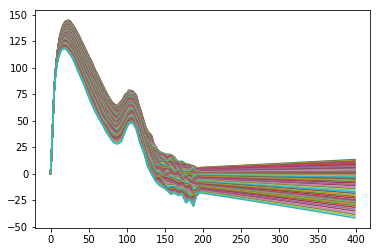

In [3063]:
for i in range(100):
    plt.plot(xi_all2[:400,i])

In [2920]:
np.sum(r_all**2*xi_all.sum(axis=1))

-7041612.901354569

In [2896]:
xi_all.shape

(1000, 200)

In [2885]:
from scipy.integrate import dblquad
dblquad(lambda mu,r: xi_interp(r,mu),0, 200, 0, 1,epsrel=1e-4)

/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


KeyboardInterrupt: 

In [ ]:
np.sum(r_all[r_all<400]**2*xi_)

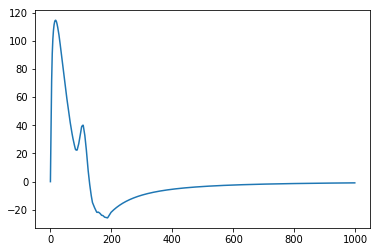

In [3078]:
plt.plot([xi_interp_r(rr)*rr**2 for rr in r_all])

In [3079]:
r_all = np.arange(0.,1000.,1)

In [3109]:
def integ_xi(m,r_max=400):
    xis = np.array([xi_interp_r(rr,m=m) for rr in r_all[r_all<r_max]])
    return np.sum(r_all[r_all<r_max]**2*xis)#*(r_all[1]-r_all[0])

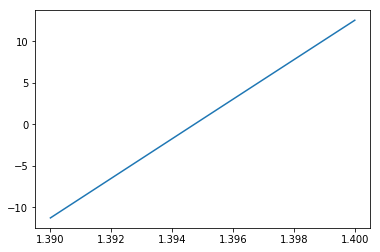

In [3110]:
m_all = np.linspace(1.39,1.4,101)
integs=[integ_xi(mm) for mm in m_all]
plt.plot(m_all,integs)

In [3171]:
for m in np.linspace(1.71,1.8,10):
    this_r = np.arange(0.01,401,1.)
    this_mu = np.linspace(1./48.,1-1./48.,24)
    xi_out = np.zeros([len(this_r),len(this_mu)])

    for ri,r in enumerate(this_r):
        for mui,mu in enumerate(this_mu):
            xi_out[ri,mui]=xi_interp(r,mu,m=m)#95)
            if r>400:
                xi_out[ri,mui]=0
    rmax=400
    print(m,np.sum(this_r[this_r<rmax]**2*xi_out.mean(axis=1)[this_r<rmax]))

1.71 -31.416788737834395
1.72 -9.779984060993229
1.73 11.748323021734905
1.74 33.16872798708573
1.75 54.481822872985504
1.76 75.68819629908103
1.77 96.78843348713872
1.78 117.78311628131269
1.79 138.67282316830642
1.8 159.45812929739077


In [ ]:
np

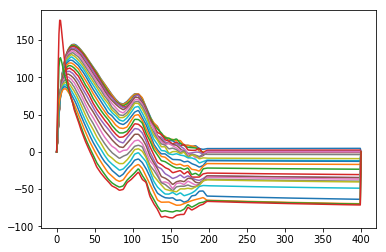

In [3162]:
for mi in range(len(this_mu)):
    plt.plot(this_r,this_r**2*xi_out[:,mi])

In [3163]:
r_integ = lambda rmax: np.sum(this_r[this_r<rmax]**2*xi_out.mean(axis=1)[this_r<rmax])

In [3164]:
ints = np.asarray([r_integ(rmax) for rmax in np.arange(100,500)])

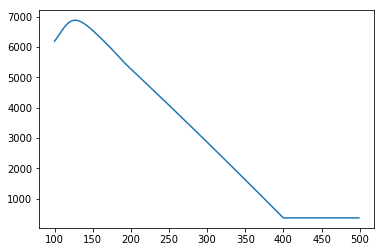

In [3165]:
plt.plot(np.arange(100,500),ints)

In [3172]:
this_r = np.arange(0.01,401,1.)
this_mu = np.linspace(1./48.,1-1./48.,24)
xi_out = np.zeros([len(this_r),len(this_mu)])

for ri,r in enumerate(this_r):
    for mui,mu in enumerate(this_mu):
        xi_out[ri,mui]=xi_interp(r,mu,m=1.725)#95)
        if r>400:
            xi_out[ri,mui]=0
rmax=400
print(m,np.sum(this_r[this_r<rmax]**2*xi_out.mean(axis=1)[this_r<rmax]))

1.8 0.9976943815017876


In [3173]:
outfile = '/mnt/store1/oliverphilcox/3PCF_QPM/xi_mean_zero.xi'
with open(outfile,"w") as out:
    for i in range(len(this_r)):
        if i<len(this_r)-1:
            out.write("%.6e\t"%this_r[i])
        else:
            out.write("%.6e\n"%this_r[i])
    for j in range(len(this_mu)):
        if j<len(this_mu)-1:
            out.write("%.6e\t"%this_mu[j])
        else:
            out.write("%.6e\n"%this_mu[j])
    for i in range(len(this_r)):
        for j in range(len(this_mu)):
            out.write("%.6e"%(xi_out[i,j]))
            if j<len(this_mu)-1:
                out.write("\t")
            else:
                out.write("\n")

In [3082]:
np.where(r_all>400)[0][0]

401

In [2733]:
xis.shape

(1000,)

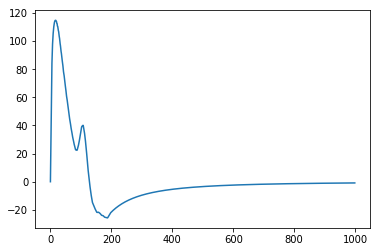

In [2789]:
xis = np.array([float(xi_interp_r(rr)) for rr in r_all])
plt.plot(r_all,r_all**2*xis)

In [2735]:
integs = [np.sum(r_all[:n]**2*xis[:n]) for n in range(1000)]

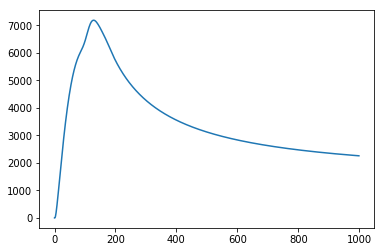

In [2736]:
plt.plot(r_all,integs)

In [2737]:
input_xi.shape

(59, 24)

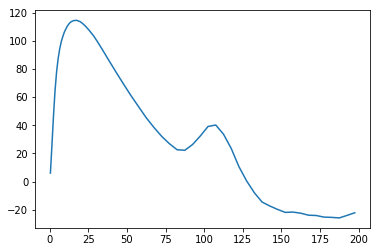

In [2738]:
plt.plot(xi_r,mu_int_xi_r*xi_r**2)

In [2739]:
xi_int = lambda n: np.sum(xi_r[:n]**2*mu_int_xi_r[:n])*(xi_r[1]-xi_r[0])

In [2740]:
ints = [xi_int(n) for n in range(100)]

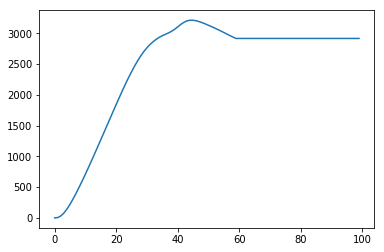

In [2741]:
plt.plot(ints)

In [2742]:
bins_r[4,0]

70.0

In [2743]:
def r2xi_model(r,R_max=400):
    if r<20:
        return 6.*r
    if r<160:
        return 120-(r-20.)*1.5
    if r<R_max:
        m=-90./(160.-R_max)
        return -90.+m*(r-160.)
    else:
        return 0.

In [2744]:
120-140*1.5

-90.0

(0, 200)

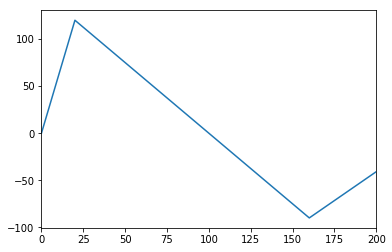

In [2745]:
r2xis = [r2xi_model(rr,R_max=233.3) for rr in r_all]
plt.plot(r_all,r2xis)
plt.xlim([0,200])

In [2746]:
this_r = np.arange(0.1,300,1.)
r2xis = [r2xi_model(rr,R_max=233.3) for rr in this_r]
xi1=np.asarray(r2xis)/this_r**2
this_mu = np.linspace(0,1.,24)

In [2747]:
xi_out=np.vstack([xi1 for _ in range(24)]).T

In [2748]:
outfile = '/mnt/store1/oliverphilcox/3PCF_SE/xi_test.xi'
with open(outfile,"w") as out:
    for i in range(len(this_r)):
        if i<len(this_r)-1:
            out.write("%.6e\t"%this_r[i])
        else:
            out.write("%.6e\n"%this_r[i])
    for j in range(len(this_mu)):
        if j<len(this_mu)-1:
            out.write("%.6e\t"%this_mu[j])
        else:
            out.write("%.6e\n"%this_mu[j])
    for i in range(len(this_r)):
        for j in range(len(this_mu)):
            out.write("%.6e"%(xi_out[i,j]))
            if j<len(this_mu)-1:
                out.write("\t")
            else:
                out.write("\n")

In [2749]:
np.genfromtxt('/mnt/store1/oliverphilcox/3PCF_SE/xi_test.xi',max_rows=1,skip_header=1)

array([0.        , 0.04347826, 0.08695652, 0.1304348 , 0.173913  ,
       0.2173913 , 0.2608696 , 0.3043478 , 0.3478261 , 0.3913043 ,
       0.4347826 , 0.4782609 , 0.5217391 , 0.5652174 , 0.6086957 ,
       0.6521739 , 0.6956522 , 0.7391304 , 0.7826087 , 0.826087  ,
       0.8695652 , 0.9130435 , 0.9565217 , 1.        ])

In [2750]:
np.loadtxt('/mnt/store1/oliverphilcox/3PCF_SE/xi_test.xi',skiprows=2)[this_r>100]

array([[-1.497004e-05, -1.497004e-05, -1.497004e-05, ..., -1.497004e-05,
        -1.497004e-05, -1.497004e-05],
       [-1.614290e-04, -1.614290e-04, -1.614290e-04, ..., -1.614290e-04,
        -1.614290e-04, -1.614290e-04],
       [-3.021754e-04, -3.021754e-04, -3.021754e-04, ..., -3.021754e-04,
        -3.021754e-04, -3.021754e-04],
       ...,
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00, ...,  0.000000e+00,
         0.000000e+00,  0.000000e+00],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00, ...,  0.000000e+00,
         0.000000e+00,  0.000000e+00],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00, ...,  0.000000e+00,
         0.000000e+00,  0.000000e+00]])

In [2751]:
test=np.loadtxt('/home/oliverphilcox/COMAJE/test_xi')

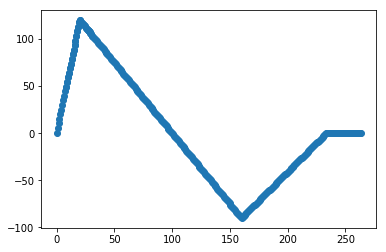

In [2752]:
plt.scatter(test[:,0],test[:,1]*test[:,0]**2)

In [2753]:
xi1[this_r<111]

array([ 6.00000000e+01,  5.45454545e+00,  2.85714286e+00,  1.93548387e+00,
        1.46341463e+00,  1.17647059e+00,  9.83606557e-01,  8.45070423e-01,
        7.40740741e-01,  6.59340659e-01,  5.94059406e-01,  5.40540541e-01,
        4.95867769e-01,  4.58015267e-01,  4.25531915e-01,  3.97350993e-01,
        3.72670807e-01,  3.50877193e-01,  3.31491713e-01,  3.14136126e-01,
        2.96651073e-01,  2.65829608e-01,  2.39245716e-01,  2.16169112e-01,
        1.96019352e-01,  1.78330503e-01,  1.62725151e-01,  1.48895031e-01,
        1.36586416e-01,  1.25588975e-01,  1.15727199e-01,  1.06853734e-01,
        9.88441494e-02,  9.15928113e-02,  8.50095888e-02,  7.90172158e-02,
        7.35491594e-02,  6.85478891e-02,  6.39634613e-02,  5.97523564e-02,
        5.58765182e-02,  5.23025556e-02,  4.90010776e-02,  4.59461351e-02,
        4.31147516e-02,  4.04865266e-02,  3.80432993e-02,  3.57688615e-02,
        3.36487135e-02,  3.16698537e-02,  2.98205983e-02,  2.80904255e-02,
        2.64698406e-02,  

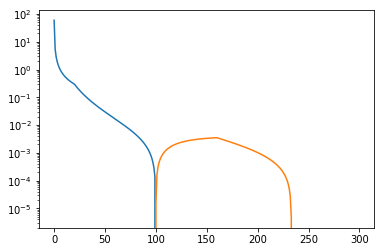

In [2754]:
plt.plot(this_r,xi1)
plt.plot(this_r,-xi1)
plt.yscale('log')

In [2755]:
np.sum(np.asarray(r2xis)[r_all<400])

IndexError: boolean index did not match indexed array along dimension 0; dimension is 300 but corresponding boolean dimension is 1000

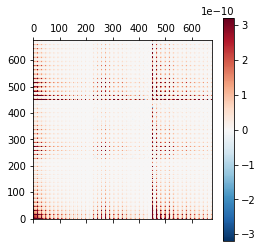

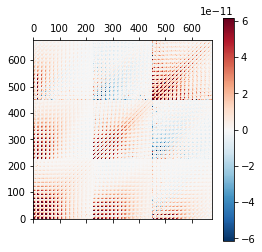

In [2756]:
plotter(rebinner(symmetrize(c60)))
plotter(rebinner(symmetrize(c61)))

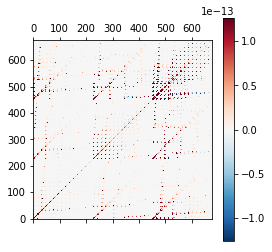

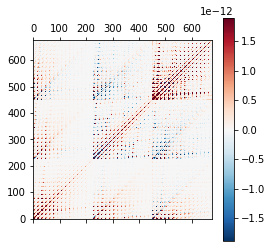

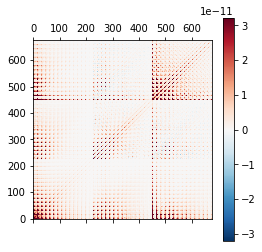

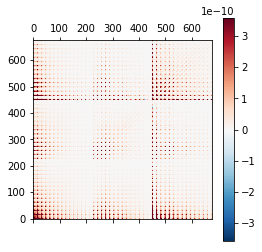

In [2757]:
plotter(rebinner(c3s))
plotter(rebinner(c4s))
plotter(rebinner(c5s))
plotter(rebinner(c6s))

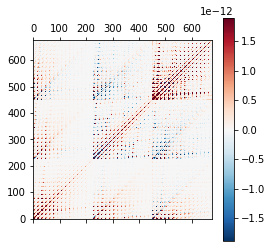

In [2758]:
plotter(rebinner(c4s))

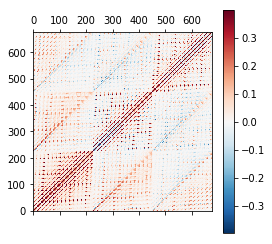

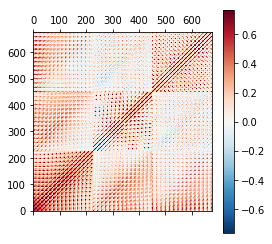

In [2759]:
plotter(reduce(rebinner(c4s)))
plotter(reduce(rebinner(c5s)))

In [3381]:
def reduce(mat):
    out_mat = np.zeros_like(mat)
    for i in range(len(mat)):
        for j in range(len(mat)):
            out_mat[i,j]=mat[i,j]/np.sqrt(mat[i,i]*mat[j,j])
    return out_mat

/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


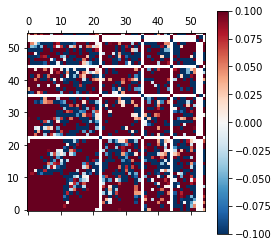

In [3382]:
plotter(reduce(c6se+c5se+c4se+c3se))

**Difference between two C3 estimates**~

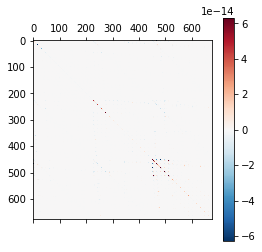

In [2762]:
mat=rebinner(symmetrize(c30-c31))
vmax=np.percentile(rebinner(symmetrize(c30)),99.)
plt.matshow(mat,vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r);
plt.colorbar();

In [2763]:
tot_mat = symmetrize(c3+c4+c5+c6)

## Total Matrix

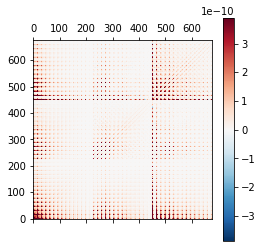

<Figure size 432x288 with 0 Axes>

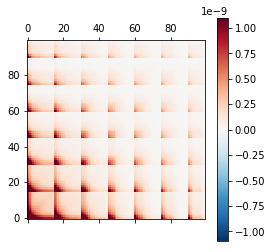

In [2764]:
plotter(rebinner(symmetrize(tot_mat)))
plt.figure()
plotter(rebinner(symmetrize(tot_mat))[:100,:100])

In [2765]:
b30=np.loadtxt(indir+'binct_c3_n%d_l%d_0_full.txt'%(n,l))
b40=np.loadtxt(indir+'binct_c4_n%d_l%d_0_full.txt'%(n,l))
b50=np.loadtxt(indir+'binct_c4_n%d_l%d_0_full.txt'%(n,l))
b60=np.loadtxt(indir+'binct_c4_n%d_l%d_0_full.txt'%(n,l))
b31=np.loadtxt(indir+'binct_c4_n%d_l%d_0_full.txt'%(n,l))
b41=np.loadtxt(indir+'binct_c4_n%d_l%d_0_full.txt'%(n,l))
b51=np.loadtxt(indir+'binct_c5_n%d_l%d_0_full.txt'%(n,l))
b61=np.loadtxt(indir+'binct_c6_n%d_l%d_0_full.txt'%(n,l))

**6-point Sampling**

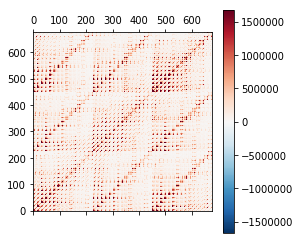

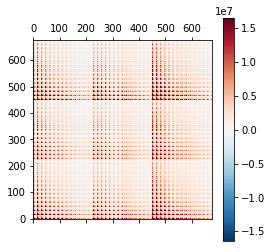

In [2766]:
plotter(rebinner(symmetrize(b60)))
plotter(rebinner(symmetrize(b61)))

**3 Point**

(0, 300)

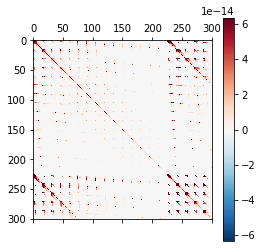

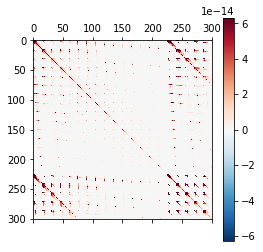

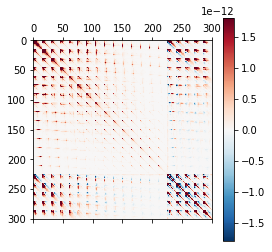

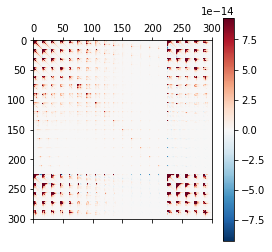

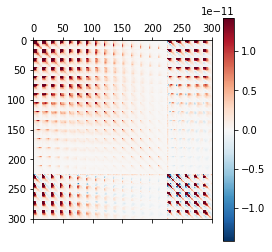

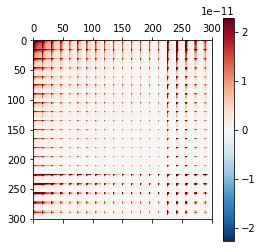

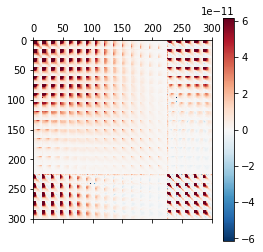

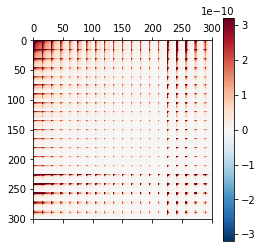

In [2767]:
plotter(rebinner(symmetrize(c31)));plt.ylim([300,0]);plt.xlim([0,300])
plotter(rebinner(symmetrize(c30)));plt.ylim([300,0]);plt.xlim([0,300])
plotter(rebinner(symmetrize(c41)));plt.ylim([300,0]);plt.xlim([0,300])
plotter(rebinner(symmetrize(c40)));plt.ylim([300,0]);plt.xlim([0,300])
plotter(rebinner(symmetrize(c51)));plt.ylim([300,0]);plt.xlim([0,300])
plotter(rebinner(symmetrize(c50)));plt.ylim([300,0]);plt.xlim([0,300])
plotter(rebinner(symmetrize(c61)));plt.ylim([300,0]);plt.xlim([0,300])
plotter(rebinner(symmetrize(c60)));plt.ylim([300,0]);plt.xlim([0,300])

In [2768]:
def collapse_axes(mat,c_bin,d_bin):
    new_mat = np.zeros([m,m,n,n])
    for i in range(len(mat)):
        p_bin = i%m
        a_bin = (i//m)//n
        b_bin = (i//m)%n
        for q_bin in range(m):
            new_mat[p_bin,q_bin,a_bin,b_bin] = mat[i,c_bin*n+d_bin*m+q_bin]
    return new_mat

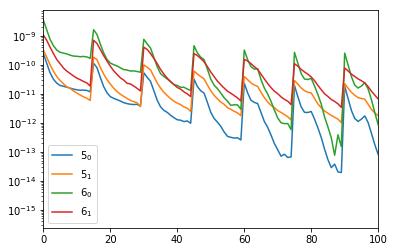

In [2769]:
plt.plot(np.diag(rebinner(symmetrize(c50)))[:n*n],label=r'$5_0$')
plt.plot(np.diag(rebinner(symmetrize(c51)))[:n*n],label=r'$5_1$')
plt.plot(np.diag(rebinner(symmetrize(c60)))[:n*n],label=r'$6_0$')
plt.plot(np.diag(rebinner(symmetrize(c61)))[:n*n],label=r'$6_1$')
plt.legend();plt.xlim([0,100])
plt.yscale('log');

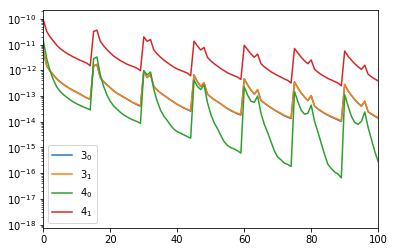

In [2770]:
plt.plot(np.diag(rebinner(symmetrize(c30)))[:n*n],label=r'$3_0$')
plt.plot(np.diag(rebinner(symmetrize(c31)))[:n*n],label=r'$3_1$')
plt.plot(np.diag(rebinner(symmetrize(c40)))[:n*n],label=r'$4_0$')
plt.plot(np.diag(rebinner(symmetrize(c41)))[:n*n],label=r'$4_1$')
plt.legend();plt.xlim([0,100])
plt.yscale('log');

In [2771]:
def variance(mat):
    out_mat = np.zeros([m,n,n])
    for p in range(m):
        for i in range(n):
            for j in range(n):
                out_mat[p,i,j]=mat[(i*n+j)*m+p,(i*n+j)*m+p]
    return out_mat

In [2772]:
collapsed_mat = collapse_axes(tot_mat,5,7)
collapsed_mat.shape

(3, 3, 15, 15)

In [2773]:
def collapse_axes_all_corr(mat,c_bin,d_bin):
    new_mat = np.zeros([n*m,n*m])
    for i in range(len(mat)):
        p_bin = i%m
        a_bin = (i//m)//n
        b_bin = (i//m)%n
        for q_bin in range(m):
            new_mat[p_bin*n+a_bin,q_bin*n+b_bin] += mat[i,c_bin*n*m+d_bin*m+q_bin]
    # Now compute correlation matrix
    corr_mat = np.zeros([n*m,n*m])
    for i in range(len(corr_mat)):
        p_bin = i//n
        a_bin = i%n
        for j in range(len(corr_mat[0])):
            q_bin = j//n
            b_bin = j%n
            corr_mat[p_bin*n+a_bin,q_bin*n+b_bin]=new_mat[p_bin*n+a_bin,q_bin*n+b_bin]/np.sqrt(new_mat[p_bin*n+a_bin,q_bin*n+a_bin]*new_mat[p_bin*n+b_bin,q_bin*n+b_bin])
    return corr_mat

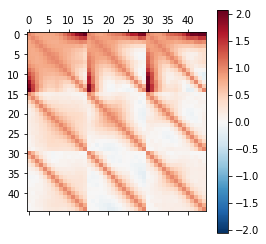

In [2774]:
collapsed_mat = collapse_axes_all_corr(tot_mat,5,7)
vmax=np.percentile(collapsed_mat,99.9)
plt.matshow(collapsed_mat,vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r);
#plt.title(r'$C_{%d%d}$'%(2*i,2*j))
plt.colorbar();

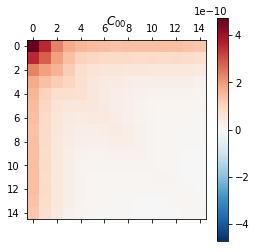

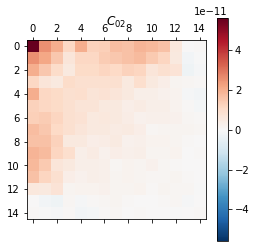

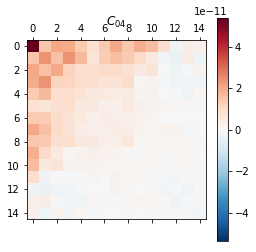

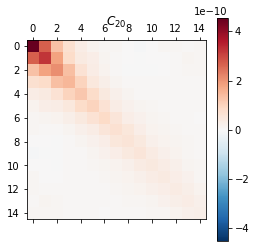

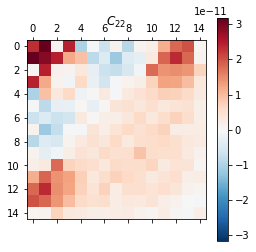

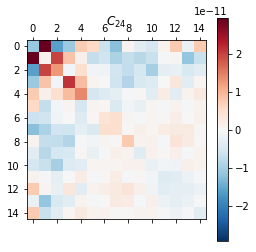

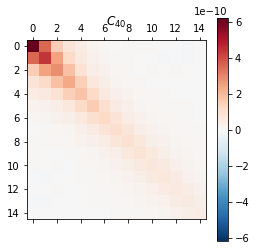

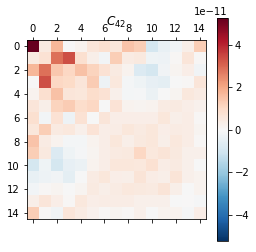

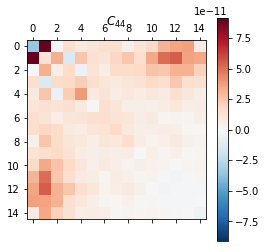

In [2775]:
collapsed_mat = collapse_axes(tot_mat,5,2)
for i in range(3):
    for j in range(3):
        vmax=np.percentile(collapsed_mat[i,j],99.9)
        plt.matshow(collapsed_mat[i,j],vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r);
        plt.title(r'$C_{%d%d}$'%(2*i,2*j))
        plt.colorbar();